# Analisis del rendimiento academico de los estudiantes

Para este analisis, contamos con un conjunto de datos de 10.000 observaciones, que miden 6 variables
* Hours Studied: Numero total de horas de estudio.
* Previous Scores: Calificaciones de examenes anteriores.
* Extracurricular Activities: Participacion en actividades extraescolares.
* Sleep Hours: Numero promedio de horas de sueño por dia.
* Sample Question Papers Practiced: Numero de ejercicios que realizo cada individuo.
* Performance Index: Media del rendimiento general del estudiante.

El objetivo sera realizar una regresion lineal multiple, tomando como variable respuesta Performance Index.

## Analisis Univariante

In [1]:
library(car)
library(psych)
library(leaps)
#Bondad
library(nortest)
library(lmtest)
library(MASS)

Loading required package: carData


Attaching package: ‘psych’


The following object is masked from ‘package:car’:

    logit


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [2]:
data <- read.csv('Student_Performance.csv')
head(data)

,Hours.Studied,Previous.Scores,Extracurricular.Activities,Sleep.Hours,Sample.Question.Papers.Practiced,Performance.Index
,<int>,<int>,<chr>,<int>,<int>,<dbl>
1,7,99,Yes,9,1,91
2,4,82,No,4,2,65
3,8,51,Yes,7,2,45
4,5,52,Yes,5,2,36
5,7,75,No,8,5,66
6,3,78,No,9,6,61



Todas las variables son numericas, exceptuando Extracurricular.Activities, que toma valores 'Yes' y 'No'

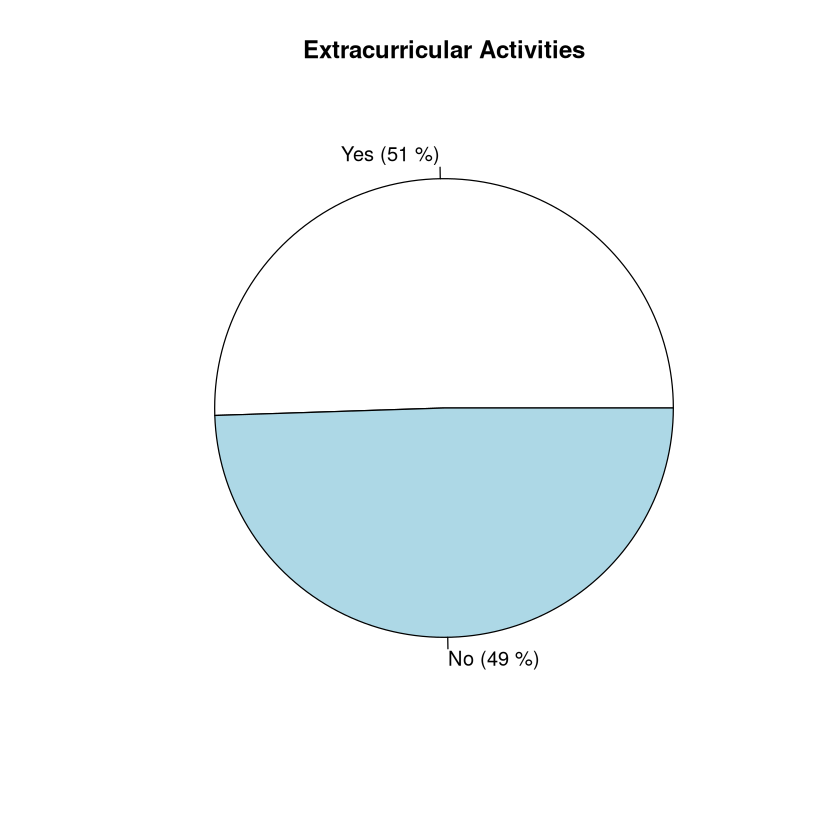

In [3]:
valores <- as.numeric(table(data$Extracurricular.Activities))
prop <- round(valores / sum(valores), 2)
labels <- c(paste0('Yes (', prop[1]*100, ' %)'), paste0('No (', prop[2]*100, ' %)'))
pie(valores, labels = labels, main = 'Extracurricular Activities')

Podemos ver que la mitad de la muestra acude a actividades extraescolares.

Vamos a analizar las variables numericas

In [4]:
for (i in c(1, 2, 4, 5, 6)){
    values <- length(unique(data[, i]))
    cat(paste0(colnames(data)[i], ': ', values, '\n'))
}

Hours.Studied: 9
Previous.Scores: 60
Sleep.Hours: 6
Sample.Question.Papers.Practiced: 10
Performance.Index: 91


Podemos ver que las Variables Hours.Studied, Sleep.Hours y Sample.Question.Papers.Practiced toman menos de 10 valores distintos.

Vamos a analizar estas mas en profundidad:

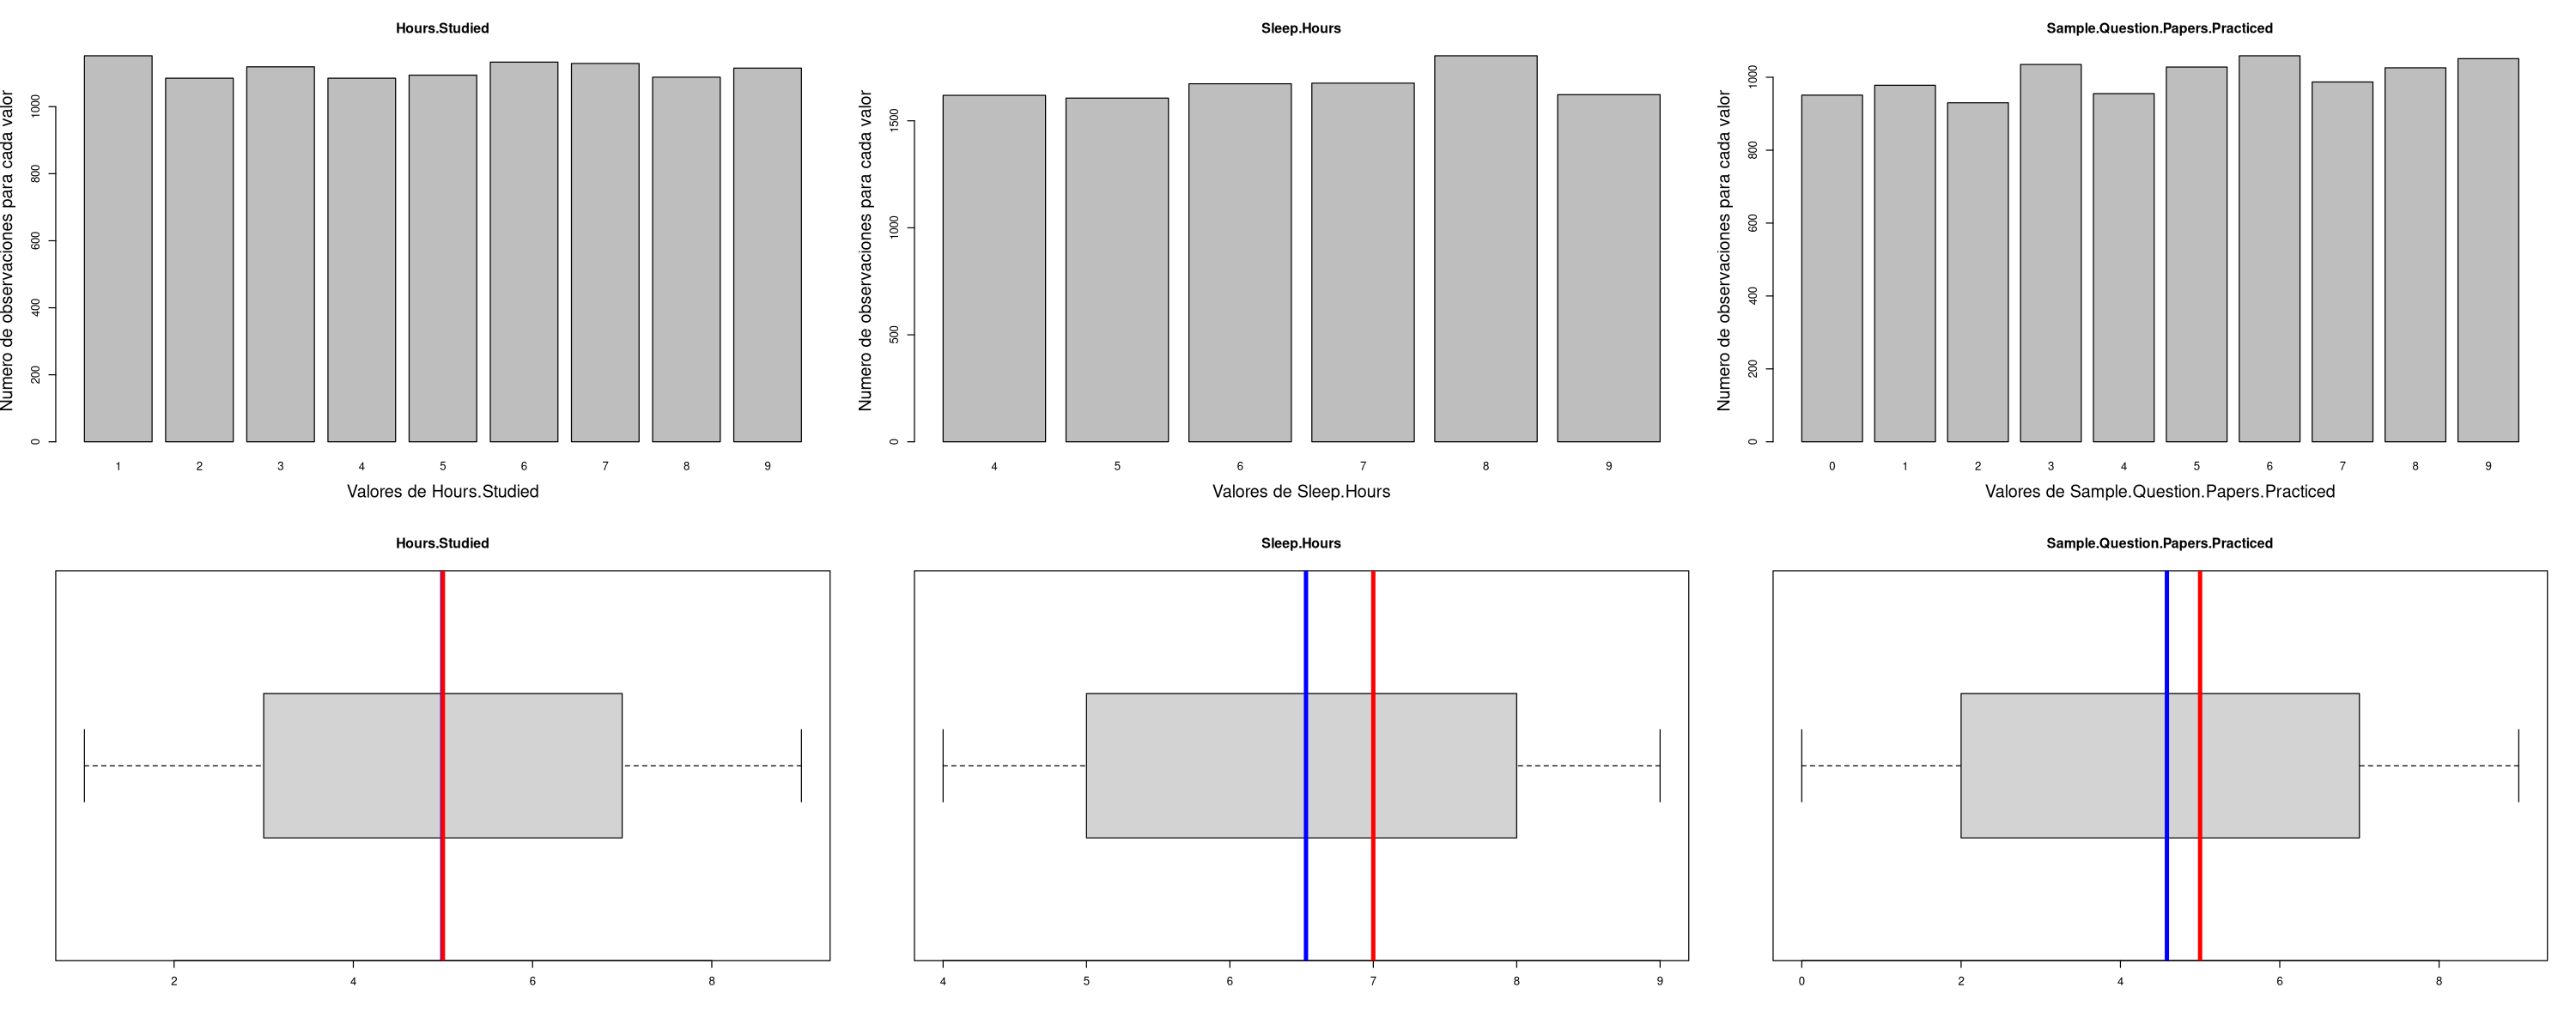

In [5]:
par(mfrow = c(2, 3))
options(repr.plot.width=25, repr.plot.height=10)
firsts_var <- c(1, 4, 5)
for ( i in firsts_var ) {
    barplot(table(data[ , i]), 
    xlab = paste0('Valores de ', colnames(data[i])), 
    ylab = 'Numero de observaciones para cada valor', 
    cex.lab = 1.5)
    title(colnames(data[i])); 
}

for ( i in firsts_var ) {
    boxplot(data[, i], horizontal =T)
    abline( v = mean(data[ ,i]), col = 'blue', lwd = 4)
    abline( v = median(data[ ,i]), col = 'red', lwd = 4)
    title(colnames(data[i]))
    }

Para visualizar la **media**, añadimos al barplot una linea vertical <u>azul</u>, para la **mediana** otra vertical <u>roja</u>.

##### Horas de estudio
* Podemos ver en el boxplot que ninguna de las valores destaca significativamente frente al resto.
* En el boxplot podemos ver que la media y la mediana toman el mismo valor, por lo que los datos se encuentran identicamente distribuidos. De esta forma, observamos que la mitad de los alumnos estudian menos 5 horas, y la otra mas de 5.

##### Horas de sueño
* Se ve como a medida que se aumentan las horas de sueño aumenta el numero de observaciones hasta las 8 horas, tomando esta un valor levemente significativo frente al resto de valores. Para 9 horas toma un valor mas pequeño que la anterior.
* Lo visto en el barplot se refleja bien en el boxplot: Vemos como difiere la mediana de la media, tomando esta valores mas grandes. Aunque parezca un cambio muy grande, la diferencia en horas de sueño seria de 30 min aproximadamente.

##### Numero de ejercicios realizados 
* Se pueden apreciar algunos picos, pero nada realmente significativo.
* La media y la mediana difieren un poco, viendo los datos, se ve que la mediana toma valor de 5, sin embargo, tiene una media un poco menor, siendo de 4.6 aproximadamente.



Tras esto, analizaremos las variables que toman mas valores distintos

In [6]:
data_summary = as.data.frame(t(apply(data[, c(2, 6)], 2, summary)))
data_summary$sd = apply(data[, c(2, 6)], 2 ,sd)
data_summary

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Previous.Scores,40,54,69,69.4457,85,99,17.34315
Performance.Index,10,40,55,55.2248,71,100,19.21256


* Podemos ver que, en las calificaciones previas, ningun individuo tiene menos de un 40 y toma como valor maximo 99, sin embargo, en la media del rendimiento general, la nota minima es de 10 y va hasta 100.

* En ambas variables, la media y la mediana son aproximadamente iguales, ya que la diferencia es de menos de 0.5, y podemos ver que el rendimiento general fue significativamente menor que las calificaciones psadas: 
    * En las calificaciones previas, suspendieron menos del 25% de la clase, y mas del 50% sacaron notas superiores a 69 sobre 100
    * En el rendimiento general, mas del 25% de la clase suspendio con notas menores o iguales a 40 de 100, y tan solo el 50% de la clase saco notas superiores a un 55 de 100, lo que es mucho menos que en las calificaciones previas.


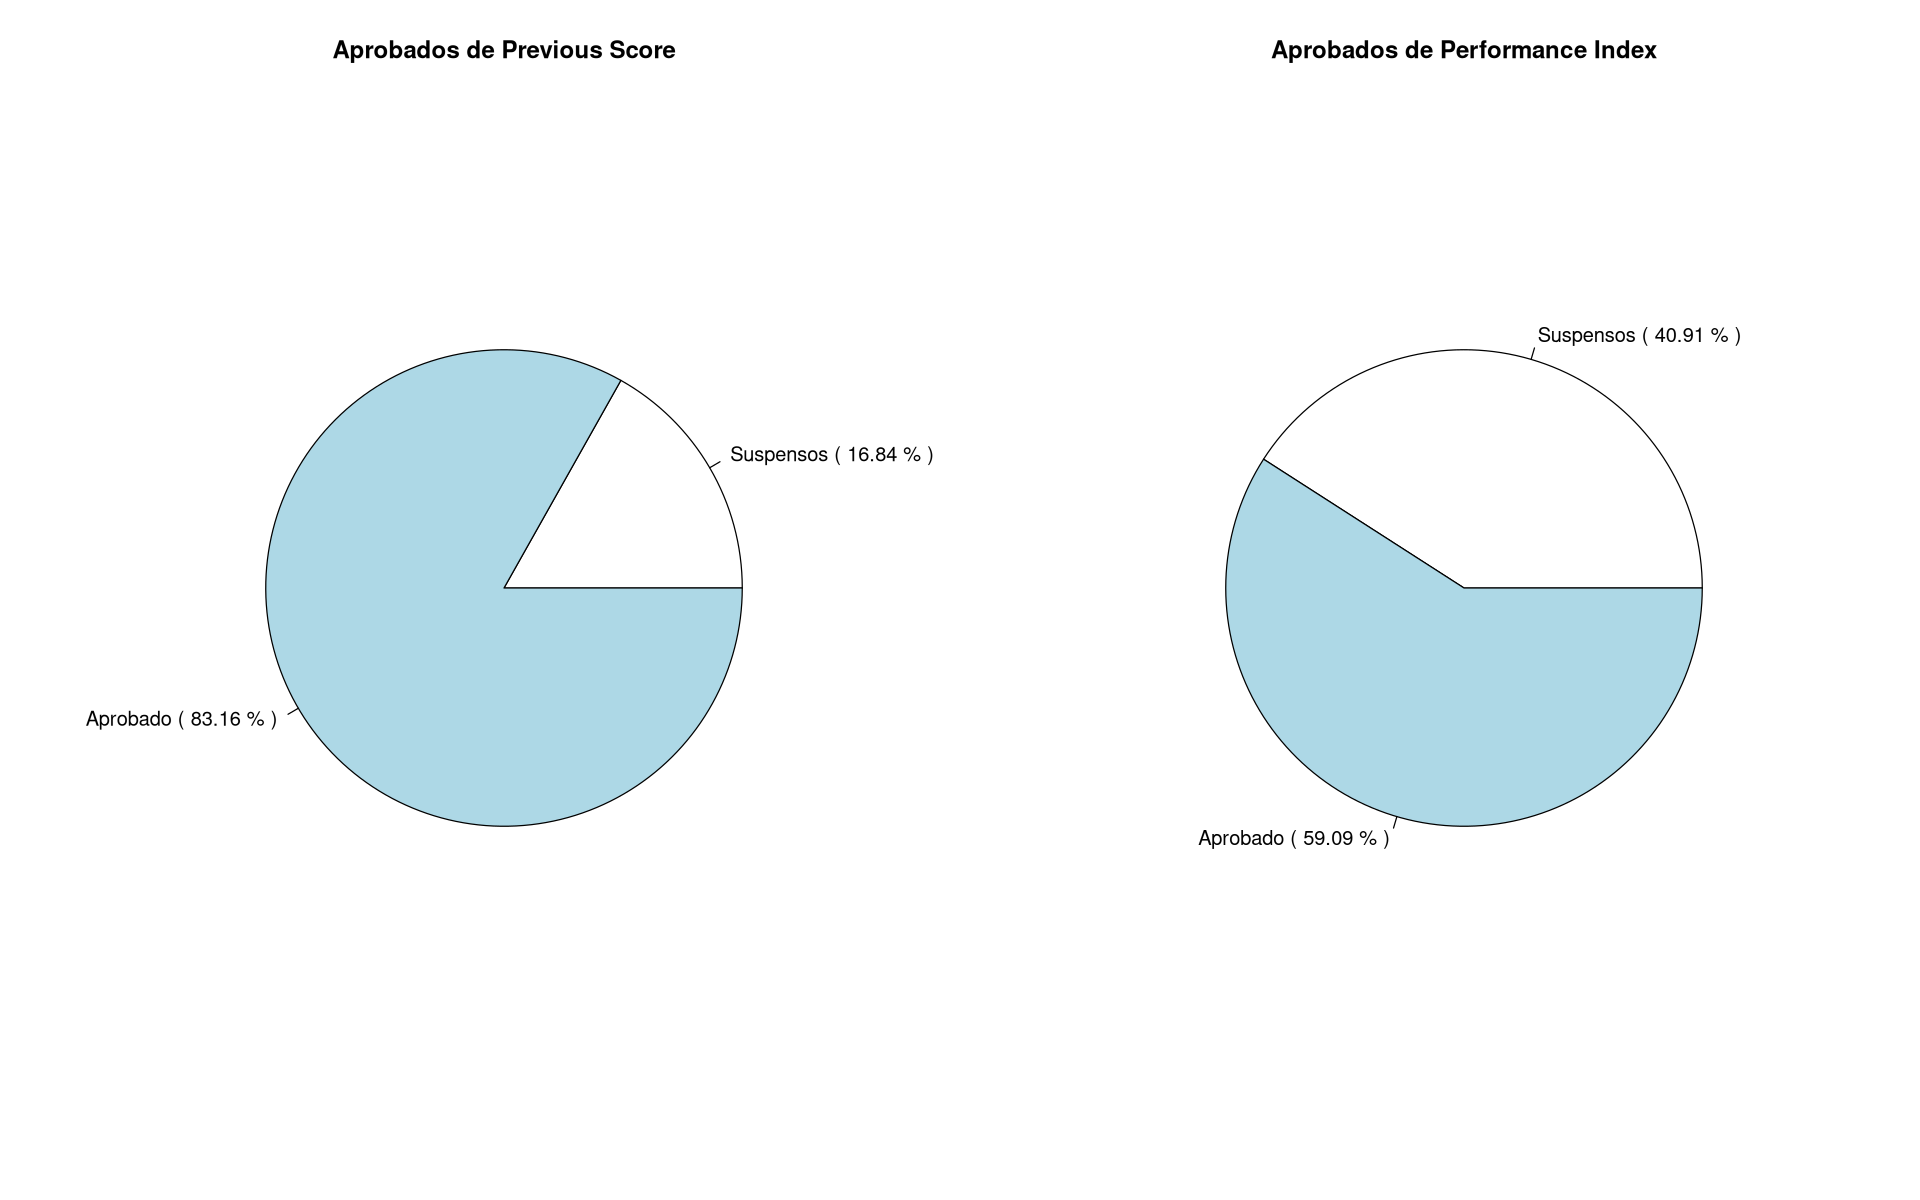

In [7]:
pre_sus <- sum(data[, 2]<50); pre_ap <- 10000 - pre_sus
ren_sus <- sum(data[, 6]<50); ren_ap <- 10000 - ren_sus
salida_pre <- paste0(' Previous Score\n', 'Numero de suspensos: ', pre_sus, '\n', 'Numero de aprobados: ', pre_ap, '\n\n')
salida_ren<- paste0('Performance Index\n', 'Numero de suspensos: ', ren_sus, '\n', 'Numero de aprobados: ', ren_ap)
#cat(salida_pre, salida_ren)

par(mfrow = c(1, 2))
options(repr.plot.width=16, repr.plot.height=10)
pie(c(pre_sus, pre_ap), labels = c(paste('Suspensos (', round(pre_sus/(pre_sus+pre_ap)*100, 2), '% )'), paste('Aprobado (', round(pre_ap/(pre_sus+pre_ap)*100, 2), '% )')), radius = 1.2)
title('Aprobados de Previous Score')

pie(c(ren_sus, ren_ap), labels = c(paste('Suspensos (', round(ren_sus/(ren_sus+ren_ap)*100, 2), '% )'), paste('Aprobado (', round(ren_ap/(ren_sus+ren_ap)*100, 2), '% )')), radius = 1.2)
title('Aprobados de Performance Index')

Si miramos el numero de aprobados y de suspensos, como suponiamos, aumenta significativamente:
* Para las calificaciones pasadas teniamos en torno a un 17% de suspensos.
* Para el rendimiento general, hay un mayor porcentaje de suspensos, en torno al 41% de individuos tienen una calificacion inferior a 50

Vamos a analizar sus distribuciones

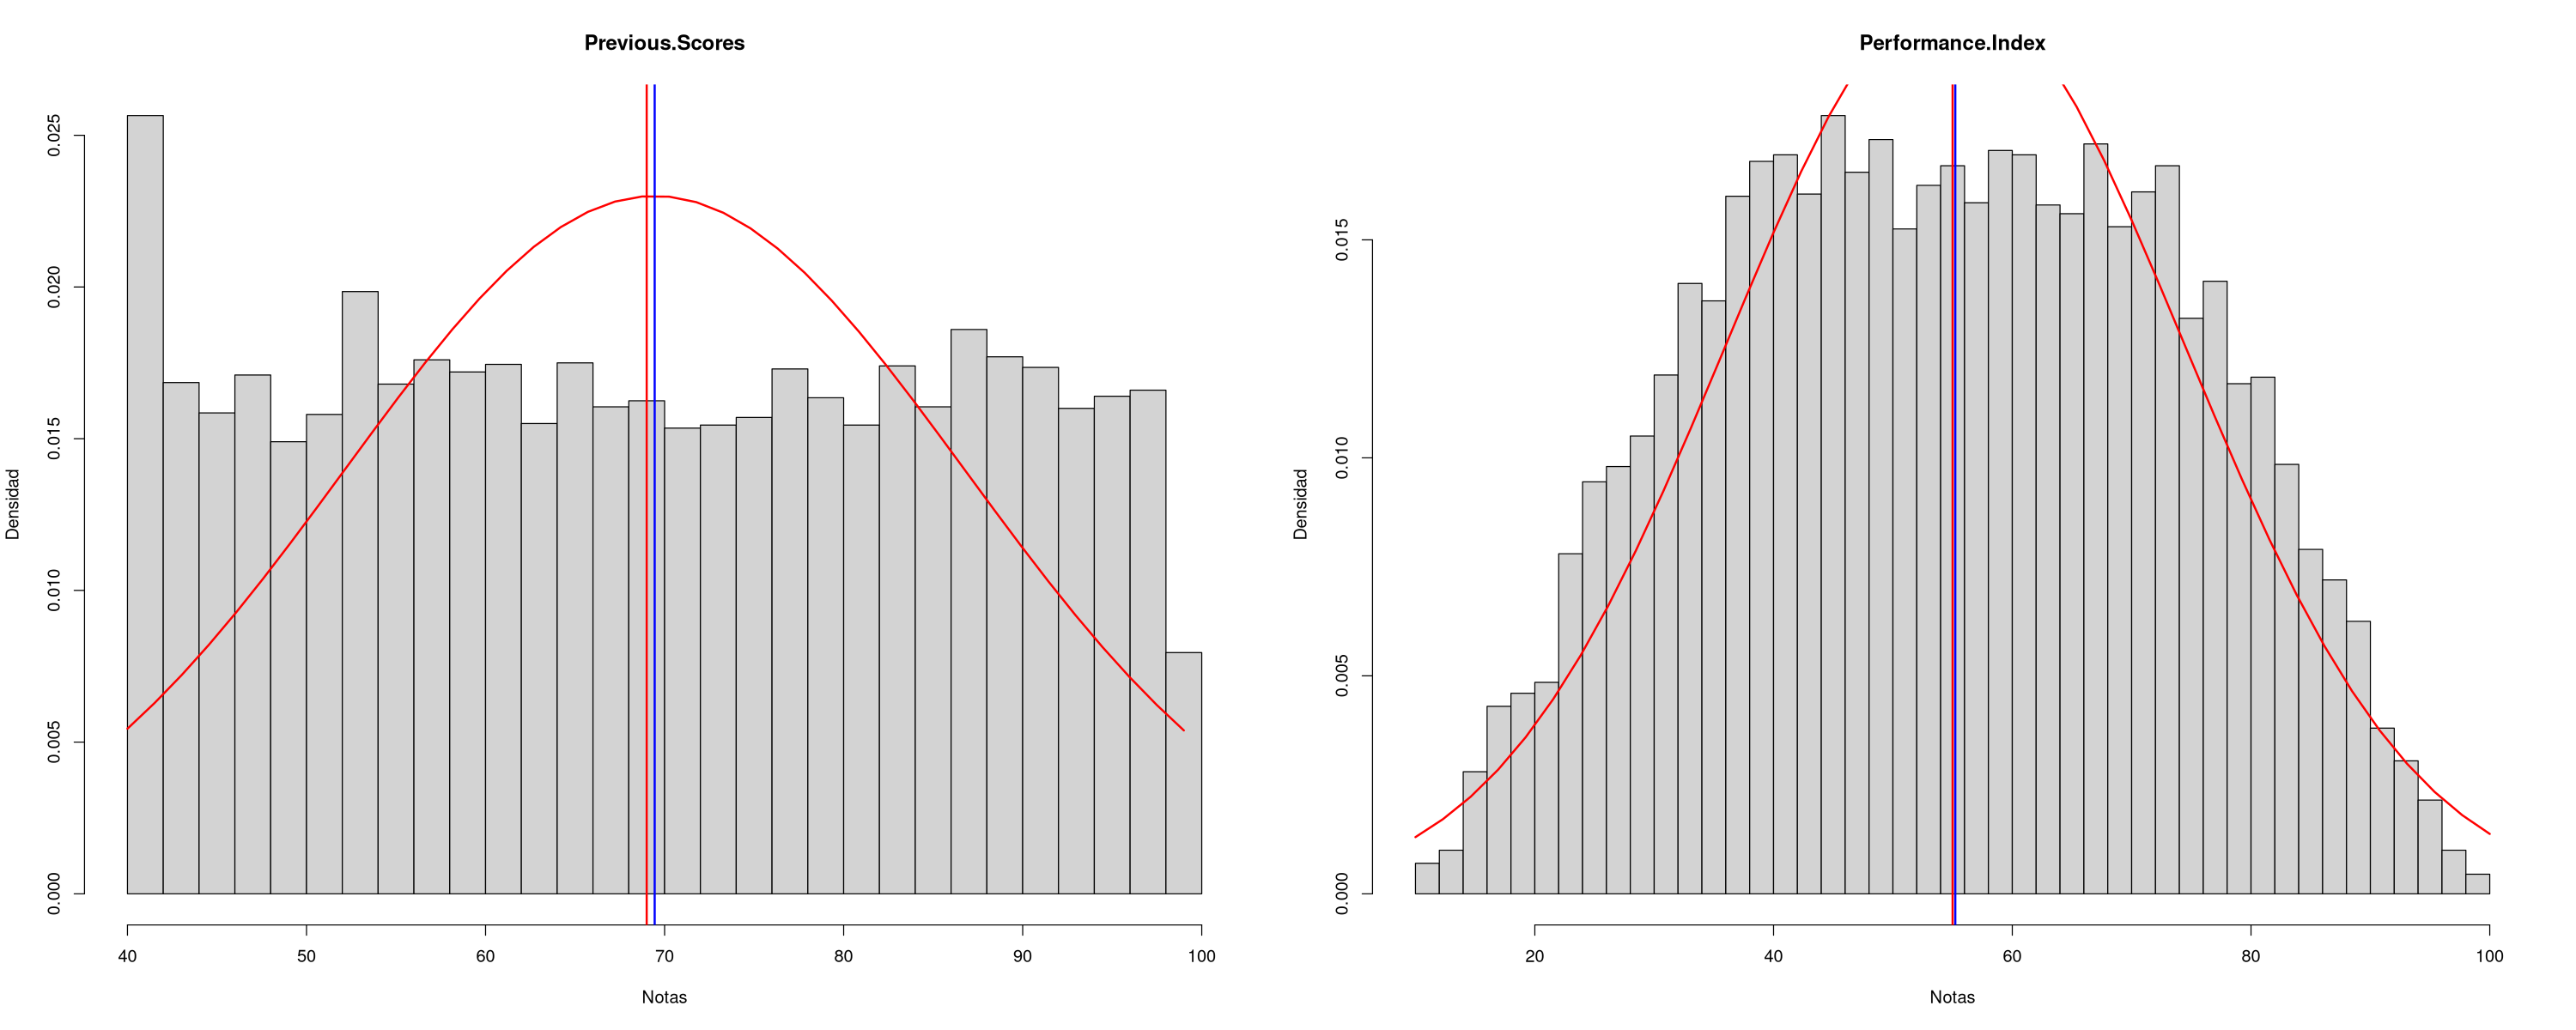

In [8]:
sec_var <- c(2, 6)
par(mfrow = c(1, 2))
options(repr.plot.width=25, repr.plot.height=10)
for (i in sec_var){
    hist(data[, i], prob = T, main = '', xlab = 'Notas', ylab = 'Densidad', breaks = 40)
    title(colnames(data[i]))
    x <- seq(min(data[, i]), max(data[, i]), length = 40)
    f <- dnorm(x, mean = mean(data[, i]), sd = sd(data[, i]))    
    lines(x, f, col = "red", lwd = 2)
    abline( v = mean(data[ ,i]), col = 'blue', lwd = 2)
    abline( v = median(data[ ,i]), col = 'red', lwd = 2)
    
}

Tras ver el histograma de estas variables, podemos concluir varias cosas:
* Para las calificaciones anteriores, vemos que podria ajustarse a una distribucion uniforme, ya que todos los datos varian en torno a la misma proporcion. Ademas, aproximadamente, donde mayor y menor frecuenia hay es en los extremos.
* Para el rendimiento general, podemos ver que si se podria aproximar a una distribucion normal.

Para sacar una buena conclusion, vamos a realizar unos test analiticos.

Para comprobar la normalidad con el test de shaphiro-wilk, cojeremos 5.000 datos de forma aleatoria, ya que es el maximo de datos que admite.

In [9]:
set.seed(123)
sample_data <- sample(1:nrow(data), 5000)

Test de normalidad para rendimiento general:

Test de normalidad para rendimiento general: 

     Prueba de Shapiro-Wilk: 6.95032740287094e-24
     Prueba de Anderson Darling: 3.7e-24
     Prueba de Lilliefors: 3.66245747742852e-54




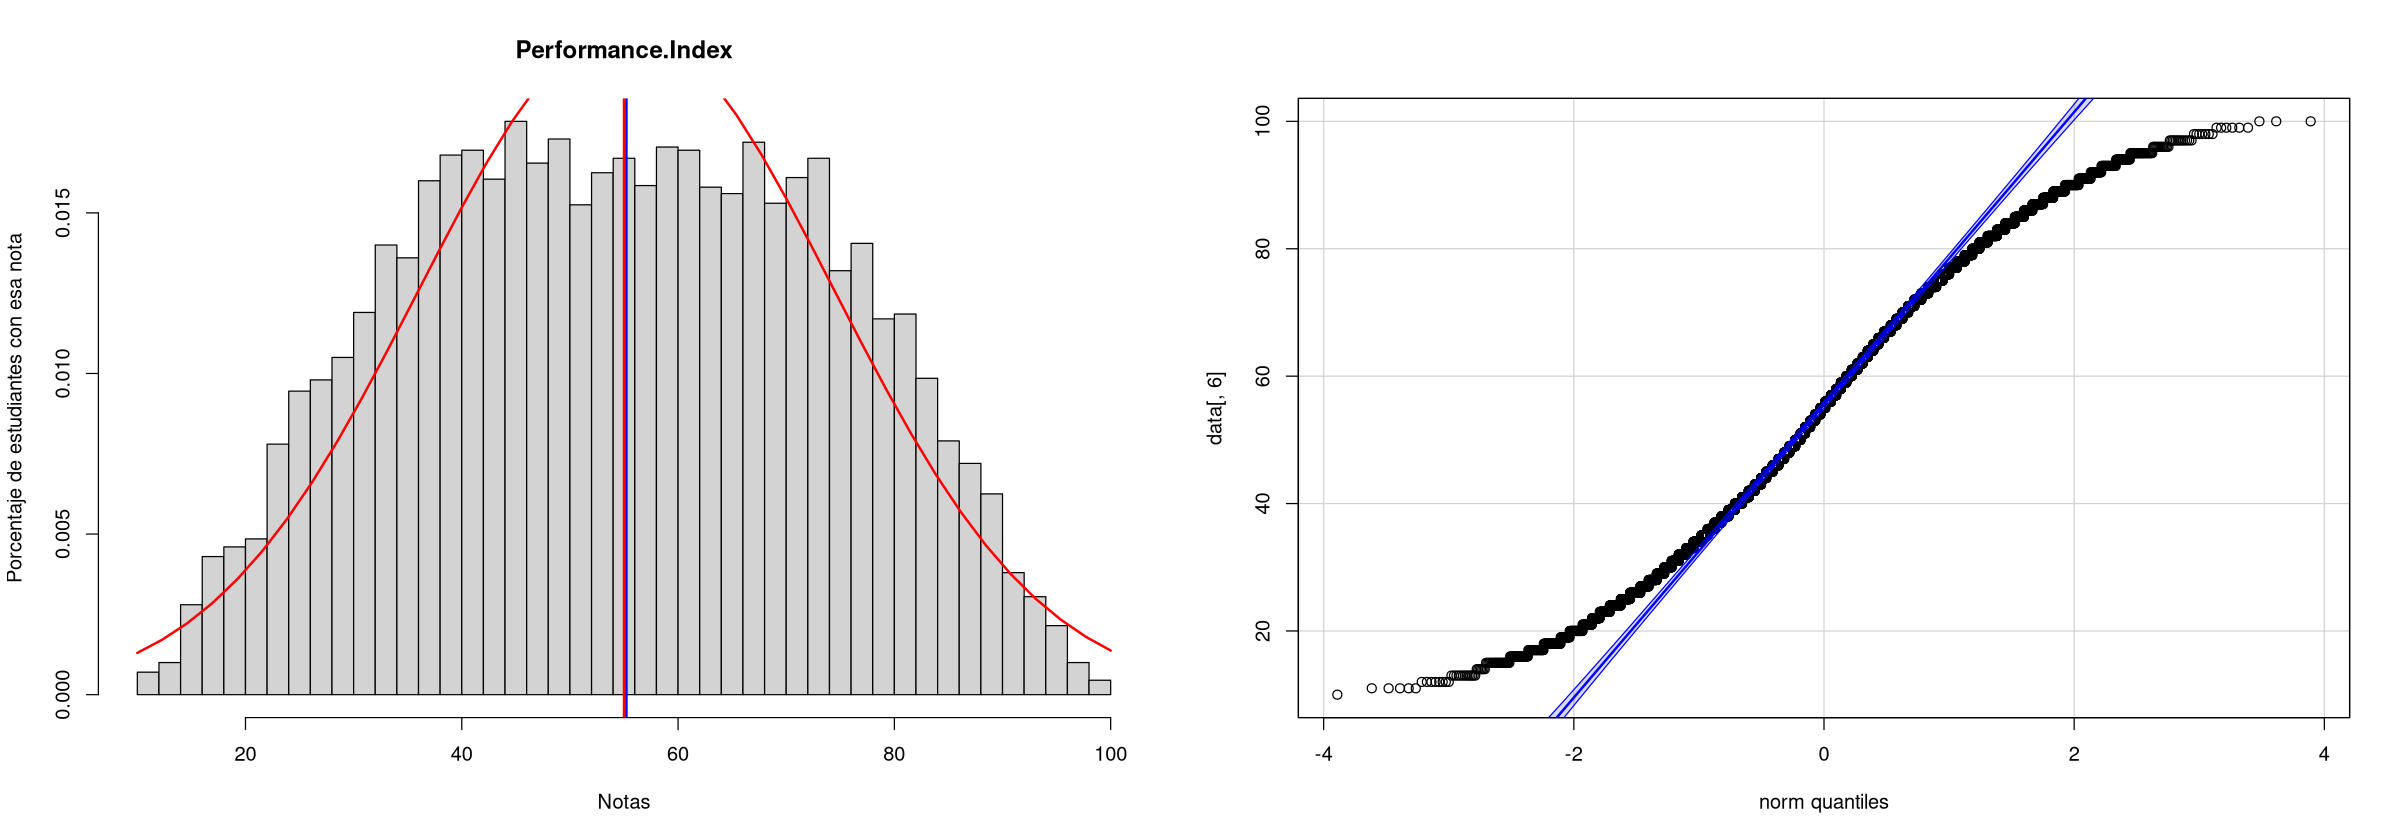

In [10]:
options(repr.plot.width=20, repr.plot.height=7)
par(mfrow = c(1, 2))
    
hist(data[, 6], prob = T, main = '', xlab = 'Notas', ylab = 'Porcentaje de estudiantes con esa nota', breaks = 40)
title(colnames(data[6]))
x <- seq(min(data[, 6]), max(data[, 6]), length = 40)
f <- dnorm(x, mean = mean(data[, 6]), sd = sd(data[, 6]))    
lines(x, f, col = "red", lwd = 2)
abline( v = mean(data[ ,6]), col = 'blue', lwd = 2)
abline( v = median(data[ ,6]), col = 'red', lwd = 2)

qqPlot(data[, 6], id=F)



shaphiro.pvalue <- shapiro.test(data[sample_data, 6])$p.value
anderson_darling.pvalue <- ad.test(data[, 6])$p.value
lliliefors_.pvalue <- lillie.test(data[, 6])$p.value

cat(paste0('Test de normalidad para ', 'rendimiento general', ': \n\n'), paste0('    Prueba de Shapiro-Wilk: ', shaphiro.pvalue, '\n'), 
    paste0('    Prueba de Anderson Darling: ', anderson_darling.pvalue, '\n'), paste0('    Prueba de Lilliefors: ', lliliefors_.pvalue, '\n\n\n'))



Los valores que hay asignados a cada test son los p-valores que devuelven.

El contraste de los test es el siguiente: 
* H0: La variable sigue una distribucion normal
* H1: La variable no sigue una distribucion normal

Tener un p-valor cercano a 0 significa rechazar la hipotesis nula (H0), lo que significa que la variable no sigue una distribucion normal.

Interpretacion de los resultados obtenidos:
* Los test analiticos nos devuelven un p-valor cercano a 0: Rechazamos la hipotesis nula
* Con test grafico Q-Q plot se ve que no sigue una distribucion normal

**Conclusion**:  A diferencia de lo esperado, rendimiento general no sigue una distribucion normal




## Analisis Multivariante

Inciaremos el analisis multivariable estudiando la matriz de correlaciones de las variables.

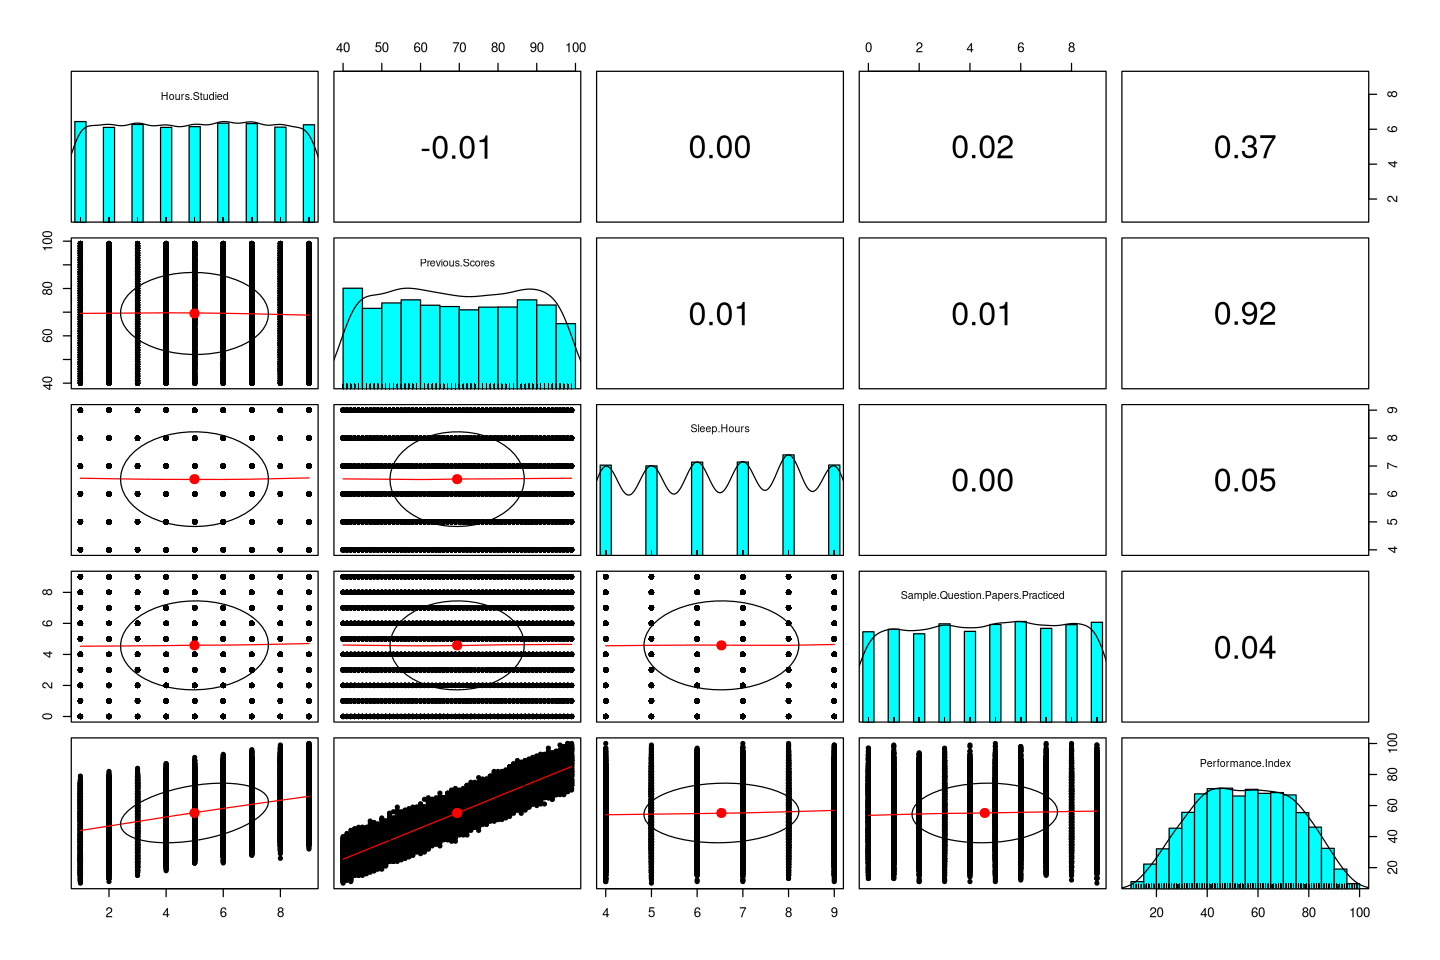

In [11]:
options(repr.plot.width=12, repr.plot.height=8)
data.numeric <- data[, -c(3)]
pairs.panels(data.numeric, smooth = T, density = T, digits = 2, ellipses = T, method = 'pearson', pch = 20, cor = T)

Podemos ver que solo hay dos variables que presentan una correlacion destacable con Performance Index.
Tomaremos como umbral 0.6 para decir que dos variables presentan una alta correlacion:
* Previous Scores: 0.92  →  Presenta una correlacion positiva muy alta 
* Hours Studied: 0.37 → Presenta una correlacion positiva moderadamente baja

Sin embargo, estas dos variables no estan nada corelacionadas entre si:  -0.01


Vamos a ver un poco, la relacion de estas dos variables frente a la Performance Index.

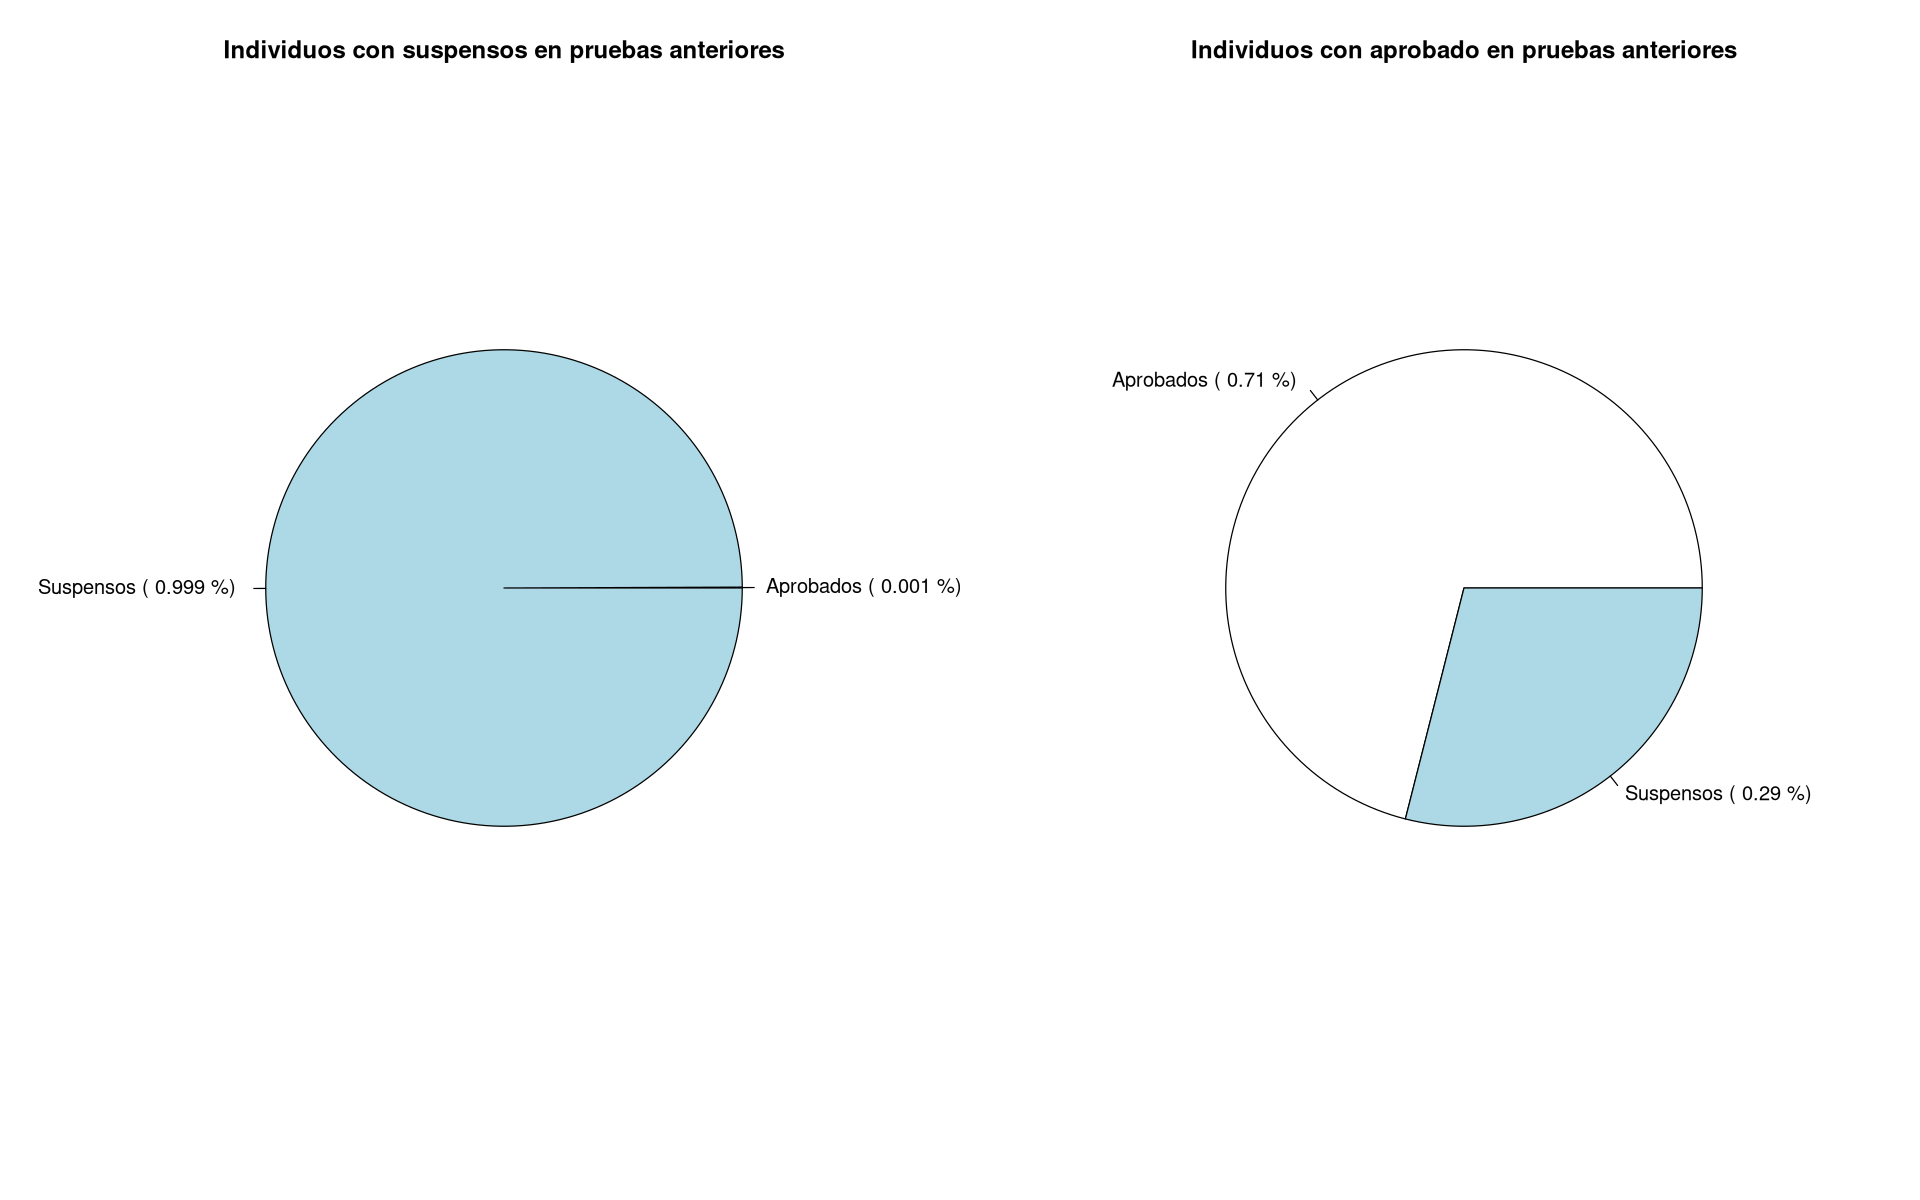

In [12]:
yes_rg <- data[data$Previous.Scores >= 50, 6]; no_rg <- data[data$Previous.Scores < 50, 6]
yes_aprobados <- sum(yes_rg>=50); no_aprobados <- sum(no_rg>=50); 
yes_suspensos <- length(yes_rg) - yes_aprobados; no_suspensos <- length(no_rg) - no_aprobados
yes <- paste0('Individuos con aprobado en pruebas anteriores \n', 'Numero de aprobados: ', yes_aprobados , '\nNumero de suspensos: ',yes_suspensos , '\n\n')
no <- paste0('Individuos con suspensos en pruebas anteriores \n', 'Numero de aprobados: ', no_aprobados , '\nNumero de suspensos: ', no_suspensos)
#cat(yes);cat(no)

par(mfrow = c(1, 2))
options(repr.plot.width=16, repr.plot.height=10)

pie(c(no_aprobados, no_suspensos), 
    labels = c(paste('Aprobados (', round(no_aprobados/length(no_rg), 3), '%) '), paste('Suspensos (', round(no_suspensos/length(no_rg), 3), '%) ')), radius = 1.2)
title('Individuos con suspensos en pruebas anteriores')

pie(c(yes_aprobados, yes_suspensos), labels = c(paste('Aprobados (', round(yes_aprobados/length(yes_rg), 3), '%) '), paste('Suspensos (', round(yes_suspensos/length(yes_rg), 3), '%) ')), radius = 1.2)
title('Individuos con aprobado en pruebas anteriores')

* Tan solo una persona que suspendio la prueba anterior, tienen un aprobado en el rendimiento general.
* Sin embargo,  muchas de las que aprobaron la prueba anterior, casi 1/3, tienen una calificacion de suspenso en el rendimiento final (2408 personas).  

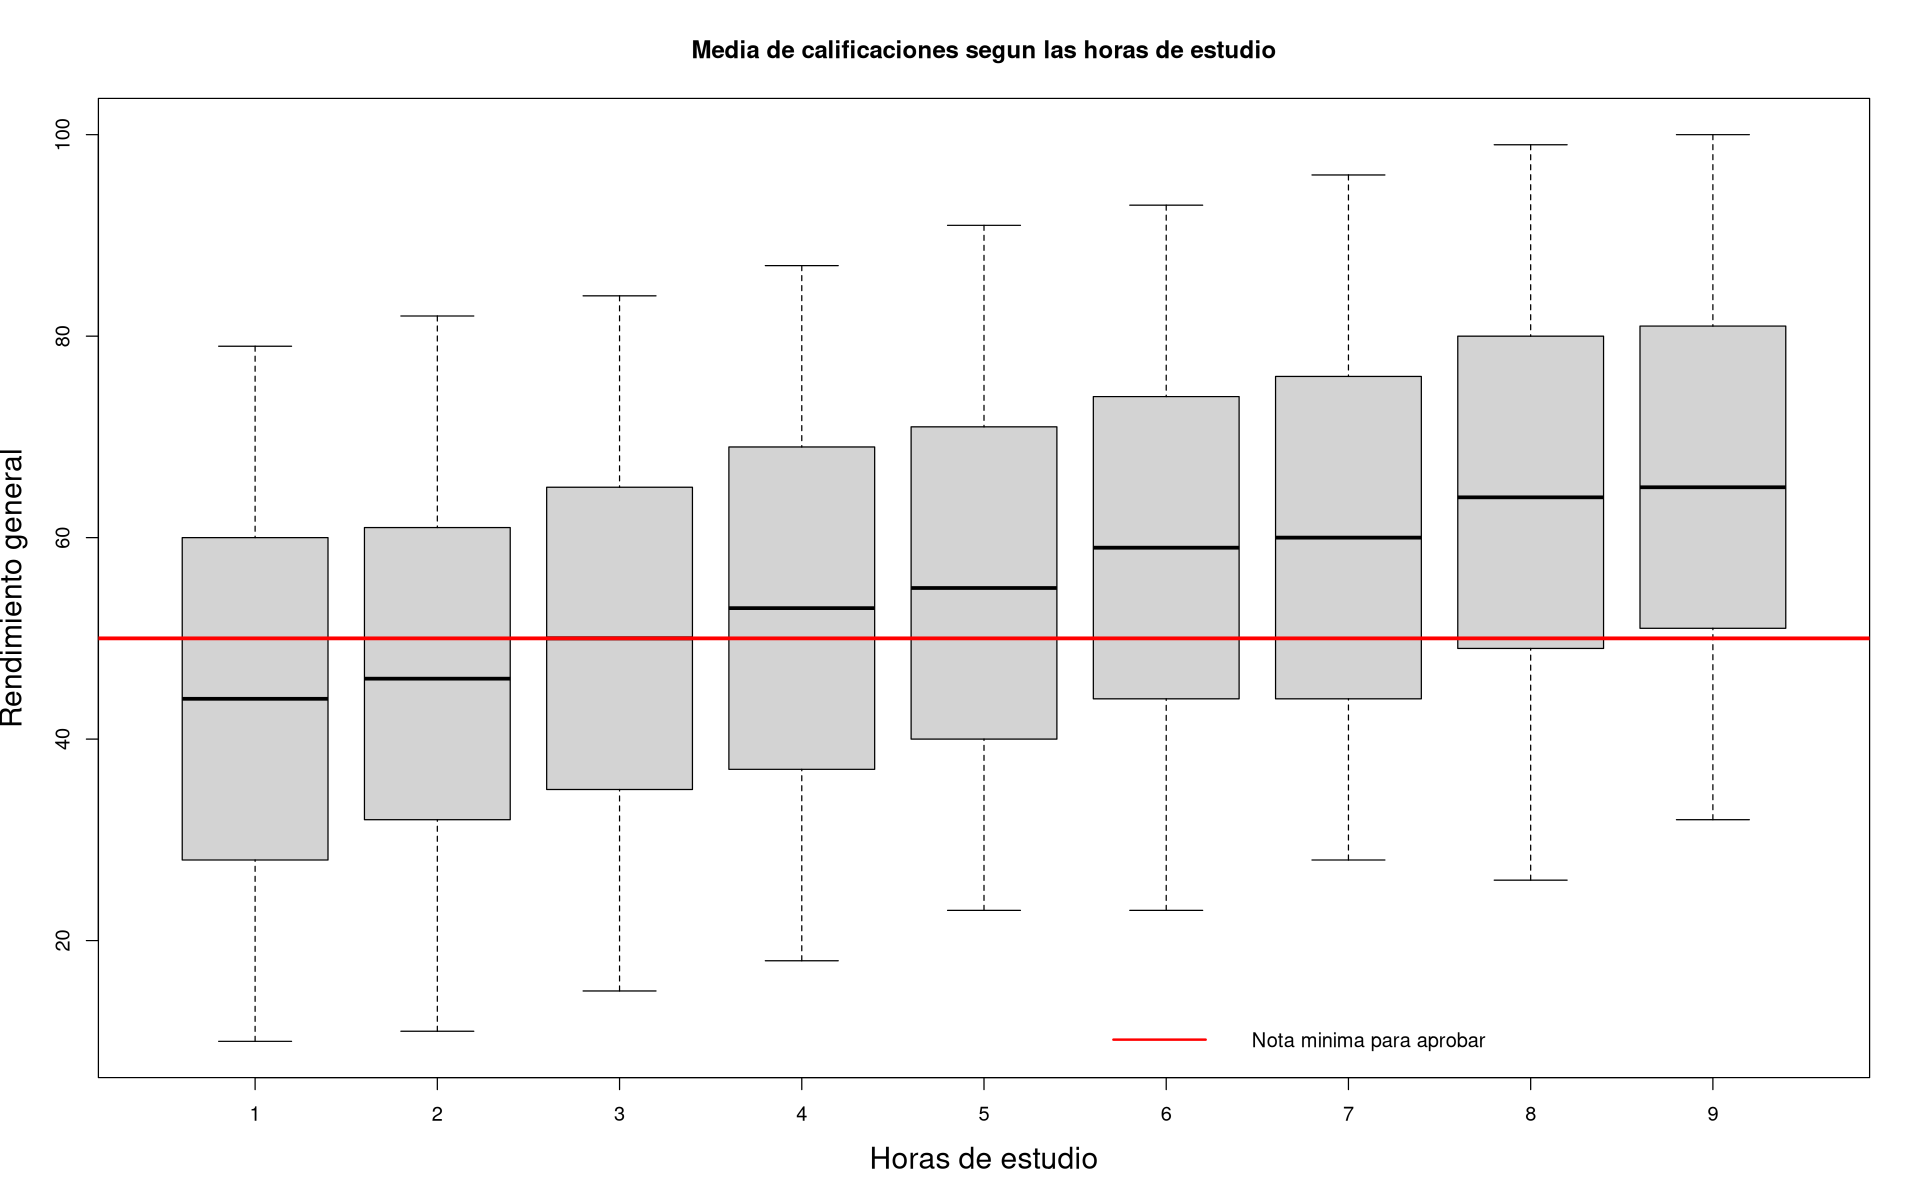

In [13]:
boxplot(Performance.Index ~ Hours.Studied, data = data,xlab = "Horas de estudio",ylab = "Rendimiento general", cex.lab = 1.5)
title("Media de calificaciones segun las horas de estudio")
abline(h = 50, col = 'red', lwd = 3)
legend("bottomright", legend = "Nota minima para aprobar", lwd = 2, col = 'red', bty = "n")

Aqui se puede observar bien como, a medida que avanzan las horas de estudio, aumenta la media, los valores mas altos, y en la mayoria de los casos, los valores mas bajos.

Hasta las 3 horas de estudio, la nota media es inferior a la nota mimima de aprobado, a partir de ahi, sube hasta 65.

In [14]:
yes_rg <- data[data$Extracurricular.Activities == 'Yes', 6]
no_rg <- data[data$Extracurricular.Activities == 'No', 6]
sus_yes_rg <- sum(yes_rg<50)
sus_no_rg <- sum(no_rg<50)
yes <- paste0('Individuos que van a extraescolares \n', 'Numero de aprobados: ',  4948-sus_yes_rg, '\nNumero de suspensos: ',sus_yes_rg)
no <- paste0('\n\nIndividuos que no van a extraescolares \n', 'Numero de aprobados: ', 5052-sus_no_rg, '\nNumero de suspensos: ', sus_no_rg)
cat(yes, no)

Individuos que van a extraescolares 
Numero de aprobados: 2950
Numero de suspensos: 1998 

Individuos que no van a extraescolares 
Numero de aprobados: 2959
Numero de suspensos: 2093

## Regresion lineal multiple

**Nota**: Ajustado simplemente para completar la parte de trota

Funciones auxiliares creadas para la obtencion de ciertos valores

In [15]:
#get_expl_var -> Proporciona que variables escoger para obtener los mejores modelos posibles con cierto numero de variables.

get_expl_var <- function(which_obj, response){ 
#Recive: summary(regsubsets(modelo))$wich y el nombre de la variable respuesta

k <- ncol(which_obj)-1 # No incluimos beta_0
expl_vars <- c()
    
for (i in 1:k){
    vars <- names(which(which_obj[i,] == TRUE)[-1])
    value <- ""
        
    for (j in 1:length(vars)){
        value <- paste0(value, vars[j], sep="+")
        }
    
    value <- paste0(response, "~", substring(value, 1, nchar(value)-1))
    expl_vars <- c(expl_vars, value)
    }
    
return(expl_vars)
}


#get_AIC -> Devuelve el AIC de todos los modelos
get_AIC <- function(models, dataset){
#Recive: todos los modelos de los que se quiere calcular el AIC, el dataset al que pertenecen
    
AIC_val <- c()
    
for (i in 1:length(models)){
    model <- lm(models[i], data = dataset)
    AIC_val <- c(AIC_val, AIC(model))
    }
    
return (AIC_val)
}

In [16]:
data.numeric <- data[, -3]
head(data.numeric)

,Hours.Studied,Previous.Scores,Sleep.Hours,Sample.Question.Papers.Practiced,Performance.Index
,<int>,<int>,<int>,<int>,<dbl>
1,7,99,9,1,91
2,4,82,4,2,65
3,8,51,7,2,45
4,5,52,5,2,36
5,7,75,8,5,66
6,3,78,9,6,61


### Seleccion del mejor modelo

El objetivo ahora, es elegir el mejor modelo de todos los posibles. Para ello, nos apoyaremos con la funcion regsubset, de la libreria leaps, que aplica un algotitmo exahustivo te devuelve el mejor modelo segun el numero de variables

In [17]:
exm_model <- regsubsets(data.numeric$Performance.Index~., data = data.numeric)
smm_exm_model <- summary(exm_model)
smm_exm_model

Subset selection object
Call: regsubsets.formula(data.numeric$Performance.Index ~ ., data = data.numeric)
4 Variables  (and intercept)
                                 Forced in Forced out
Hours.Studied                        FALSE      FALSE
Previous.Scores                      FALSE      FALSE
Sleep.Hours                          FALSE      FALSE
Sample.Question.Papers.Practiced     FALSE      FALSE
1 subsets of each size up to 4
Selection Algorithm: exhaustive
         Hours.Studied Previous.Scores Sleep.Hours
1  ( 1 ) " "           "*"             " "        
2  ( 1 ) "*"           "*"             " "        
3  ( 1 ) "*"           "*"             "*"        
4  ( 1 ) "*"           "*"             "*"        
         Sample.Question.Papers.Practiced
1  ( 1 ) " "                             
2  ( 1 ) " "                             
3  ( 1 ) " "                             
4  ( 1 ) "*"                             

Los moejores modelos para los diferentes numeros de variables son:
* [1]  **Performance Index** = **Previous_Scores** * X1
* [2]  **Performance Index** = **Hours_Studied** * X1 + **Previous_Scores** * X2 
* [3]  **Performance Index** = **Hours_Studied** * X1 + **Previous_Scores** * X2 +  **Sleep_Hours** * X3 
* [4]  **Performance Index** = **Hours_Studied** * X1 + **Previous_Scores** * X2 +  **Sleep_Hours** * X3 + **Sample_Question_Papers_Practiced** * X4

Para cual de estod modelos es el mejor, nos basamos distintos estadisticos:

Vamos a calcular los estadisticos de los modelos:

In [18]:
stats <- attributes(smm_exm_model)$names[2:6]
explicativas <- data.numeric[, -5]
response <- colnames(data.numeric)[5]
table <- c() 

for (i in 1:length(stats)){
row <- unlist(smm_exm_model[stats[i]])
table <- rbind(table, row)
}

table <- data.frame(t(matrix(table, nrow = 5)), row.names = 1:ncol(explicativas))
colnames(table) <- c("R^2", "SS(R)", "R^2_adj", "Cp", "BIC")
table$Modelo = get_expl_var(smm_exm_model$which, response)
table$AIC = get_AIC(table$Modelo, data.numeric)
table <- table[, c(2, 1, 3, 7, 5, 4, 6)]
return(table)

,SS(R),R^2,R^2_adj,AIC,BIC,Cp,Modelo
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,599501.22,0.8375712,0.8375549,69319.90,-18156.73,131152.7905,Performance.Index~Previous.Scores
2,52142.83,0.9858724,0.9858696,44900.79,-42568.64,2282.7009,Performance.Index~Hours.Studied+Previous.Scores
3,45582.90,0.9876498,0.9876461,43558.25,-43903.97,740.2058,Performance.Index~Hours.Studied+Previous.Scores+Sleep.Hours
4,42451.76,0.9884981,0.9884935,42848.60,-44606.40,5.0000,Performance.Index~Hours.Studied+Previous.Scores+Sleep.Hours+Sample.Question.Papers.Practiced


**AIC** y **BIC**: Permiten medir el ajuste del modelo y su complegidad, por lo que buscamos que sean lo menor posible.
* El modelo con mejor AIC y BIC es el modelo de 4 variables
  
**CP de Mallows**: Busca que se respete lo mismo que en el AIC y BIC, solo que, buscamos que se asemeje al numero de explicativas que tiene el modelo
* El mejor CP de Mallows lo tiene el modelo con 4 variables

**R^2 Ajustado**: Es la capacidad predictiva del modelo. Buscamos un modelo con una alta capacidad predictiva por que debe ser lo mayor posible
* El mejor R^2 ajustado lo tiene el modelo con 4 variables

Con todos estos resultados, podemos concluir que el mejor modelo en todo es el modelo que contiene las 4 variables

[4]  **Performance Index** = **Hours_Studied** * X1 + **Previous_Scores** * X2 +  **Sleep_Hours** * X3 + **Sample_Question_Papers_Practiced** * X4


In [24]:
modelo <- lm(data.numeric$Performance.Index~., data = data.numeric)
smm_md_f <- summary(modelo) 
smm_md_f


Call:
lm(formula = data.numeric$Performance.Index ~ ., data = data.numeric)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.3299 -1.3831 -0.0062  1.3701  8.4864 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      -33.763726   0.126841 -266.19   <2e-16 ***
Hours.Studied                      2.853429   0.007962  358.40   <2e-16 ***
Previous.Scores                    1.018584   0.001189  857.02   <2e-16 ***
Sleep.Hours                        0.476333   0.012153   39.19   <2e-16 ***
Sample.Question.Papers.Practiced   0.195198   0.007189   27.15   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.061 on 9995 degrees of freedom
Multiple R-squared:  0.9885,	Adjusted R-squared:  0.9885 
F-statistic: 2.147e+05 on 4 and 9995 DF,  p-value: < 2.2e-16


#### Bondad del ajuste

Una vez determinamos que modelo es el mejor, toca evaluar la bondad

Para evaluar la bondad del ajuste comprobaremos las 4 hipotesis estructurales:
* **Linealidad**: La variable respuesta varia en funcion de las explicativas.
* **Normalidad**: Los residuos siguen una distribucion normal ~N(0, σ^2).
* **Homocedasticidad**: La varianza de los residuos es constante.
* **Aleatoriedad**: Los residuos son independientes entre si.

Para comprobar estas hipotesis, existen test analiticos y graficos. En concreto, nosotros usaremos:
* **Linealidad**: Residuos vs Valores ajustados (grafico)
* **Normalidad**: Q-Q plot (Grafico)  &  test de Anderson Darling (analitico)
* **Homocedasticidad**: Residuos estandarizados vs Fitted values (grafico) & test Breusch-Pagan (analitico)
* **Aleatoriedad**: Residuos estandarizados vs Leverages (grafico) & test Ljung-Box (analitico)

Anderson Darling (Normalidad): 0.677929792128388
Breusch-Pagan (Homocedasticidad): 0.825836190613656
Ljung-Box (Aleatoriedad): 0.209167987479682

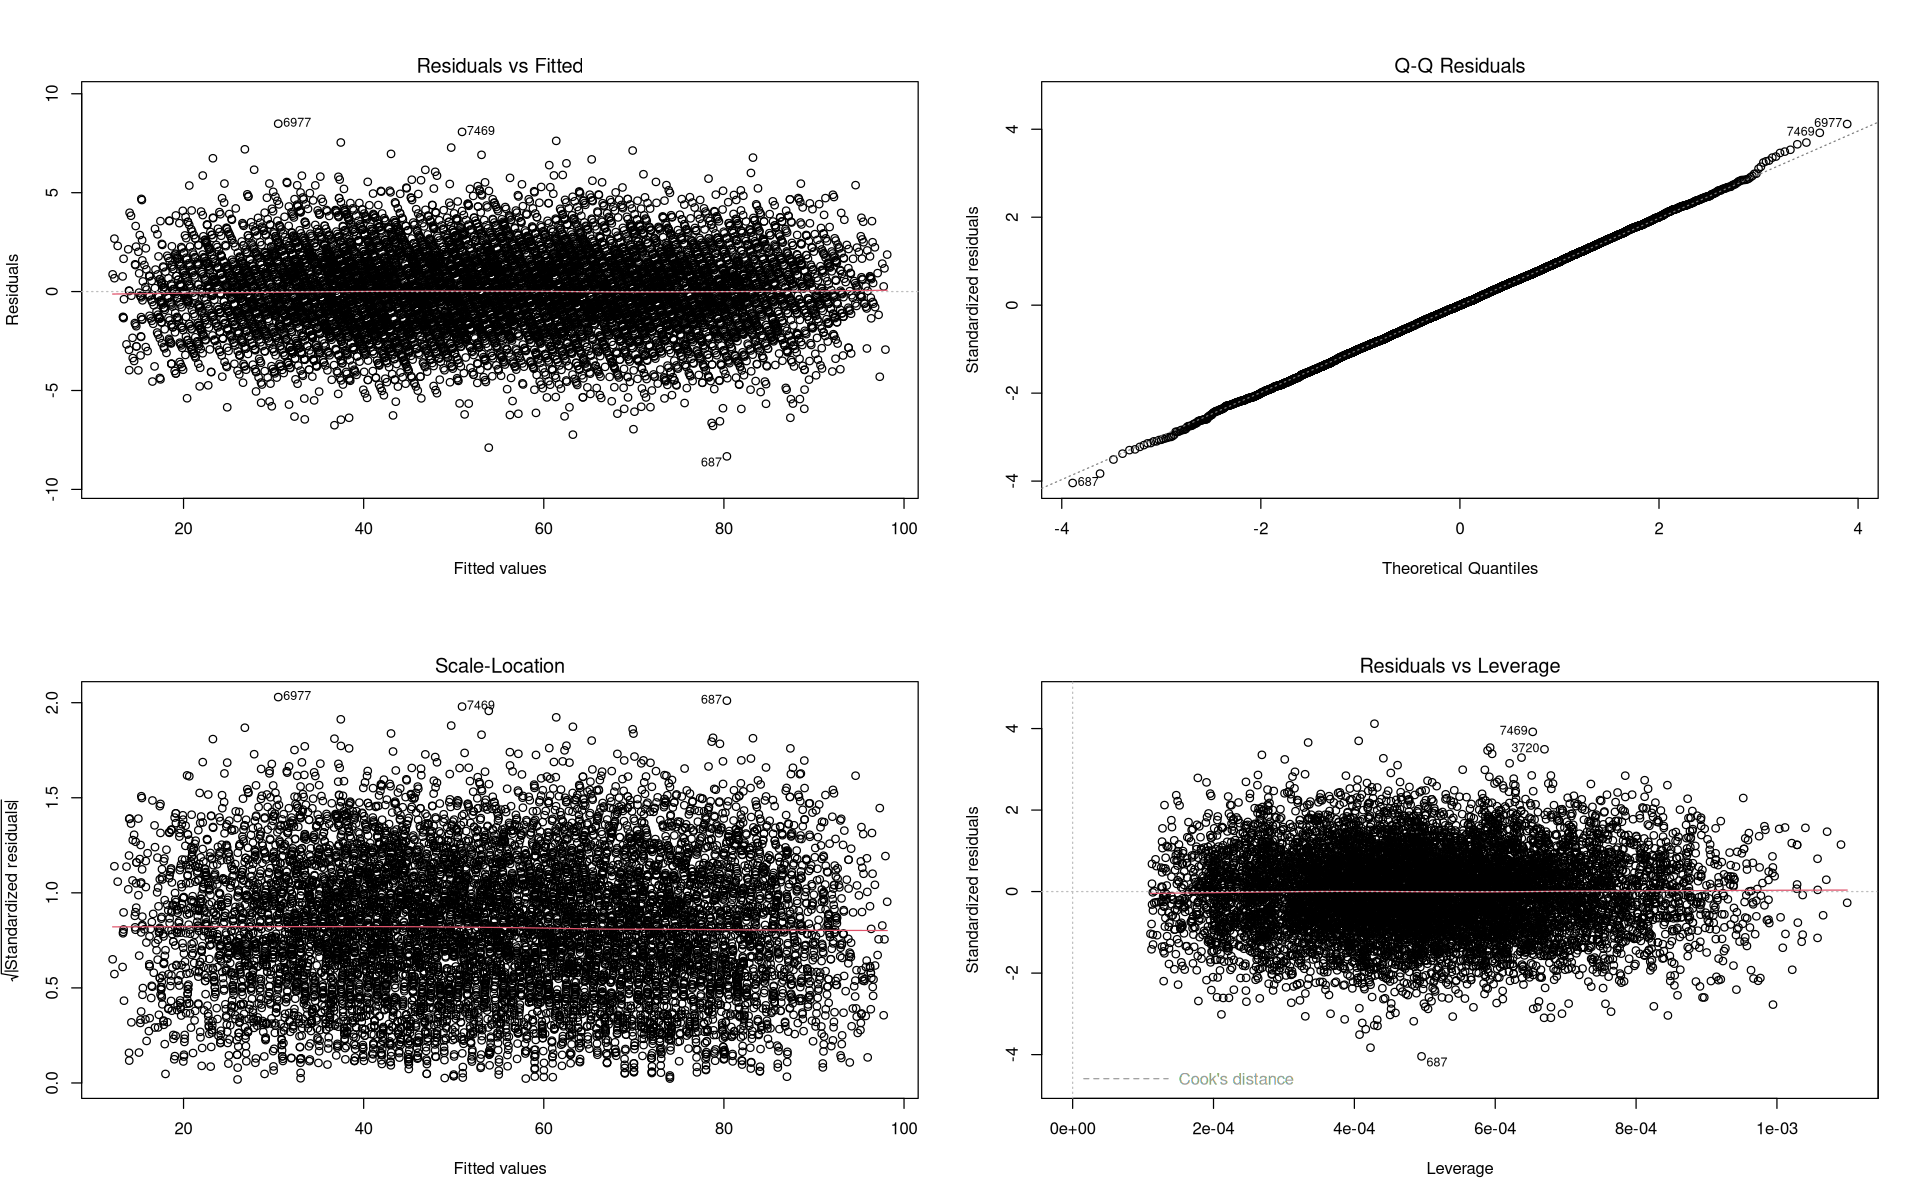

In [37]:
par(mfrow = c(2, 2))
plot(modelo)

std_residuals <- stdres(modelo)
n_ad <- ad.test(std_residuals)$p.value
h_bp <- bptest(modelo)$p.value
a_lb <- Box.test(std_residuals, type = "Ljung-Box", lag = 20)$p.value


cat(paste0('Anderson Darling (Normalidad): ', n_ad, 
          '\nBreusch-Pagan (Homocedasticidad): ', h_bp, 
          '\nLjung-Box (Aleatoriedad): ', a_lb))

El valor asociado a cada test es el p-valor del contraste que realizan.

Contraste
* H0: Se cumple la hipotesis estructural que chekea el test
* H1: No se cumple la hipotesis estructural que chekea el test

Con un nivel de significacion de 0.05, tanto para el test de normalidad, homocedasticidad y aleatoriedad, concluimos que se cumplen estas hipotesis, ya que para todos su p-value >> 0.05.

Para los test graficos, se ve como se cumple la hipotesis de linealidad, ya que vemos que los valres no siguen ninguna tendencia y oscilan entorno al 0, en una region 'cerrada' entre -6 y 6 aproximadamente